# Time Series Analysis der Audits
Dieses Notebook zeigt beispielhaft, wie die Zeitreihe über Audits analysiert werden kann. 

## Daten
Die Daten werden synthetisch generiert, da wir von HWH keine brauchbaren Daten zur Verfügung gestellt bekommen haben.
Mittels einer Sinus-Funktion, die absteigt, werden künstlich Daten generiert, die pro Monat 
die Anzahl der durchgeführten Audits darstellt. Die Sinus Funktion wurde verwendet, um eine 
Saisonalität in den Daten zu haben.  Die Daten fangen am 01.2022 an und gehen bis 01.2022. 
Am Anfang wurden noch 15 Audits durchgeführt.

In [16]:
from math import sin
import pandas as pd
import numpy.random as nr
import matplotlib.pyplot as plt

# Generierung der Daten

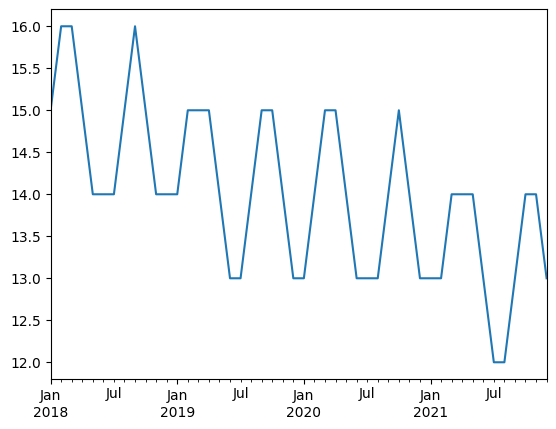

In [2]:
nr.seed(2022)
def generate_audits(start = '1-2018', end = '1-2022', freq = 'M', slope = 0.02):
    dates = pd.date_range(start = start, end = end, freq = freq)
    audits = pd.Series([round(sin(x)-x/24 + 15) for x in range(len(dates))], index = dates)
    return audits

audits = generate_audits()   
audits.plot();

# Saisonale Dekomposition
Dadurch kann der Trend und die Saisonalität der Daten analysiert werden.
Für mehr Information siehe [Dokumentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html).

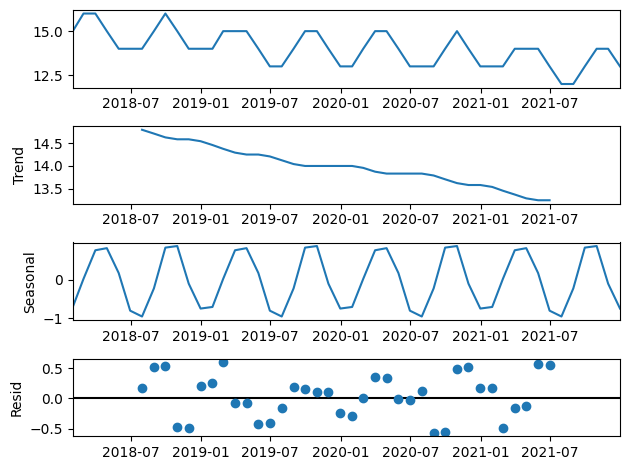

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(audits, model = 'additive')
result.plot();

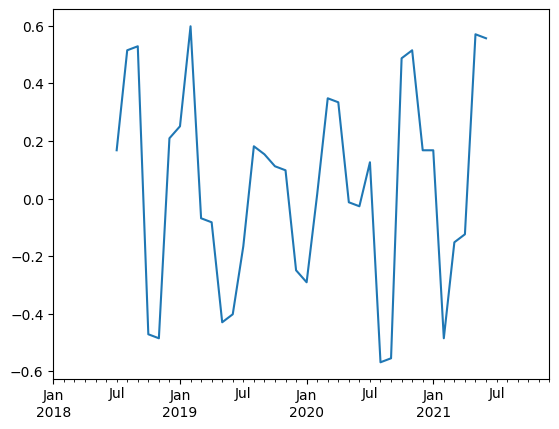

In [4]:
result.resid.plot();

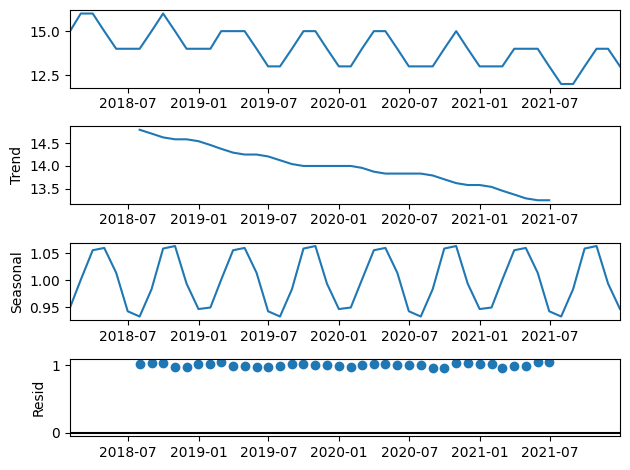

In [5]:
result = seasonal_decompose(audits, model = 'mul')
result.plot();

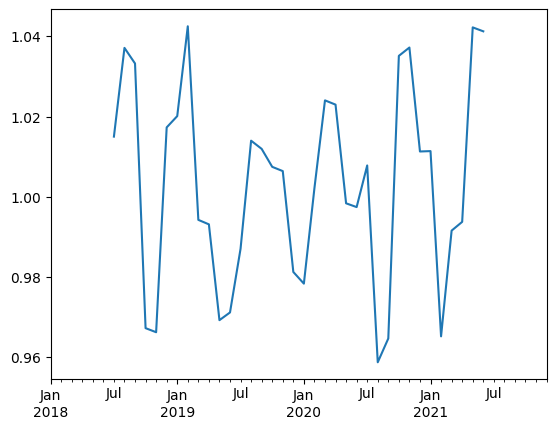

In [6]:
result.resid.plot();

# Zeitreihenvorhersage mittels SARIMAX

In [7]:
train_data = audits[:-12]
test_data = audits[-12:]

In [8]:
train_data.shape

(36,)

In [9]:
test_data.shape

(12,)

## Bestimmung der optimalen Parameter für SARIMAX
Um den folgenden Code ausführen zu können müsst ihr ggf. pmdarima installieren:
```
conda install pmdarima -c conda-forge
```

In [10]:
from pmdarima.arima import auto_arima

res = auto_arima( train_data, seasonal=True, m=12 )
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   36
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                 -13.715
Date:                             Mon, 26 Dec 2022   AIC                             33.430
Time:                                     12:32:19   BIC                             36.964
Sample:                                 01-31-2018   HQIC                            34.368
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5003      0.143     -3.505      0.000      -0.780      -0.221
ma.L1          0.6271      0.248      2.524      0.012       0.140       1.114
sigma2         0.1798      0.088      2.045      0.041       0.007       0.352
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.28
Prob(Q):                              1.00   Prob(JB):                         0.53
Heteroskedasticity (H):               1.06   Skew:                             0.18
Prob(H) (two-sided):                  0.94   Kurtosis:                         1.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Erstellung des Models

In [13]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(endog=train_data, order=res.order, seasonal_order=res.seasonal_order).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   36
Model:             SARIMAX(0, 0, 1)x(0, 1, [], 12)   Log Likelihood                 -18.660
Date:                             Mon, 26 Dec 2022   AIC                             41.321
Time:                                     12:33:53   BIC                             43.677
Sample:                                 01-31-2018   HQIC                            41.946
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7274      0.186      3.902      0.000       0.362       1.093
sigma2         0.2687      0.105      2.564      0.010       0.063       0.474
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):                 0.97
Prob(Q):                              0.57   Prob(JB):                         0.62
Heteroskedasticity (H):               0.50   Skew:                             0.21
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Evaluation des Models

## Plotten der Ergebnisse

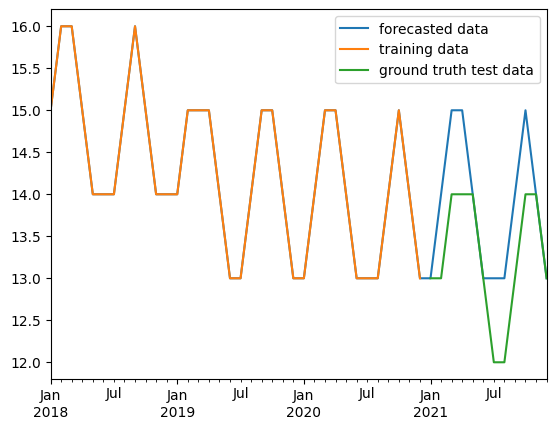

In [37]:
audits_pred = audits.copy()
audits_pred[-12:] = [ int(x) for x in model.forecast(12)]

audits_pred.plot(label="forecasted data")
train_data.plot(label="training data")
test_data.plot(label="ground truth test data")

plt.legend()
plt.show()

## Berechnung des Fehlers
Um den Fehler zu bestimmen wird der RMSE verwendet

In [41]:
pred_data = pred_data[-12:]
pred_data, test_data.to_list()

([13, 14, 15, 15, 14, 13, 13, 13, 14, 15, 14, 13],
 [13, 13, 14, 14, 14, 13, 12, 12, 13, 14, 14, 13])

[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]


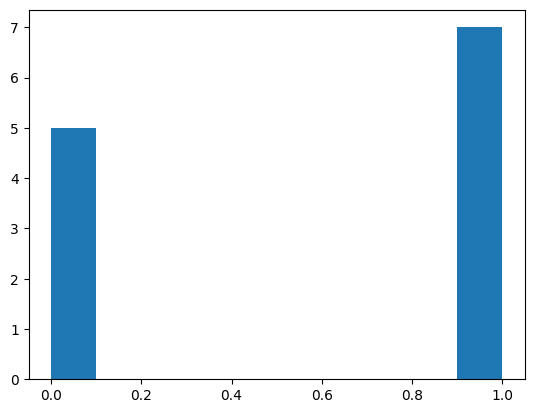

In [44]:
from sklearn.metrics import mean_squared_error

pred_data = pred_data[-12:]

rmse = []
for i in range(len(test_data)):
    error = mean_squared_error( [test_data.to_list()[i]], [pred_data[i]], squared=False )
    rmse.append( error )
    
print(rmse)
plt.hist(rmse);

*Hinweis: Um herauszufinden, welches Model am besten geeignet ist, für die realen Daten, werden reale Daten benötigt. Auch muss ein geeignetes Model durch experimentelle Vorgehenseweise gefunden werden. Dieses Notebook dient bloß als anreiz zu einer Idee. Es ist evtl. möglich das eine Zeitreihenanalyse auf den Audits Sinn machen könnte*